In [1]:
import itertools

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sns.set_style('darkgrid')

In [3]:
plot_params = {'legend.fontsize': 20,
               'figure.figsize': (20, 10),
               'axes.labelsize':  15,
               'axes.titlesize':  30,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}


#plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

## Load Data

In [4]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now


### Draw macro economic variables

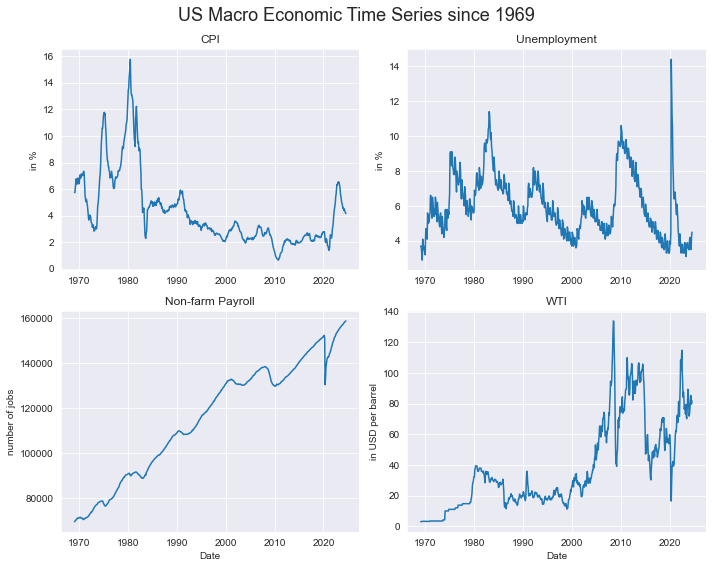

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


axes[0, 0].plot(df['CPI'])
axes[0, 0].set_title('CPI')
axes[0, 0].set_ylabel('in %')

axes[0, 1].plot(df['Unemployment'])
axes[0, 1].set_title('Unemployment')
axes[0, 1].set_ylabel('in %')

axes[1, 0].plot(df['non-farm payroll'])
axes[1, 0].set_title('Non-farm Payroll')
axes[1, 0].set_ylabel('number of jobs')
axes[1, 0].set_xlabel('Date')


axes[1, 1].plot(df['WTI'])
axes[1, 1].set_title('WTI')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('in USD per barrel')

plt.suptitle('US Macro Economic Time Series since 1969', fontsize = 18)
plt.tight_layout()
plt.show()


### Draw timeseries of four asset classes

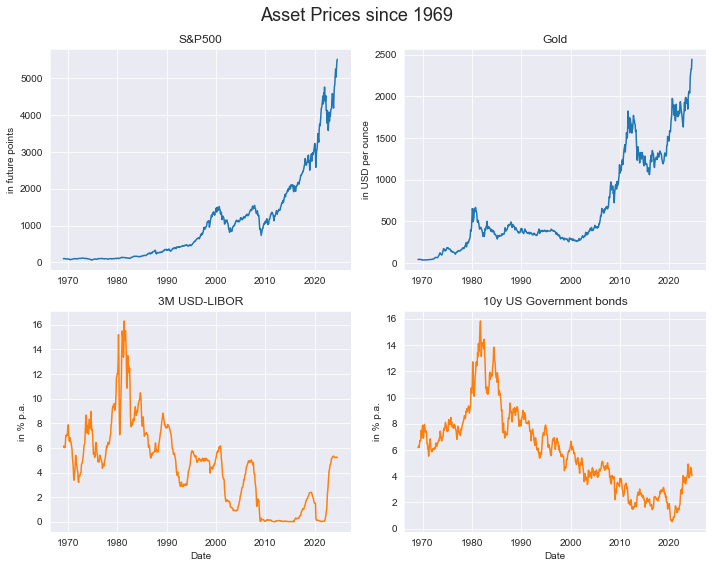

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


axes[0, 0].plot(df['SP500'])
axes[0, 0].set_title('S&P500')
axes[0, 0].set_ylabel('in future points')

axes[0, 1].plot(df['Gold'])
axes[0, 1].set_title('Gold')
axes[0, 1].set_ylabel('in USD per ounce')

axes[1, 0].plot(df['3M'], color='#ff7f0e')
axes[1, 0].set_title('3M USD-LIBOR')
axes[1, 0].set_ylabel('in % p.a.')
axes[1, 0].set_xlabel('Date')


axes[1, 1].plot(df['10y'], color='#ff7f0e')
axes[1, 1].set_title('10y US Government bonds')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('in % p.a.')


plt.suptitle('Asset Prices since 1969', fontsize = 18)
plt.tight_layout()
plt.show()

### Calculate price index of 10 year government bond

In [7]:
df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)

### Draw normalized time series

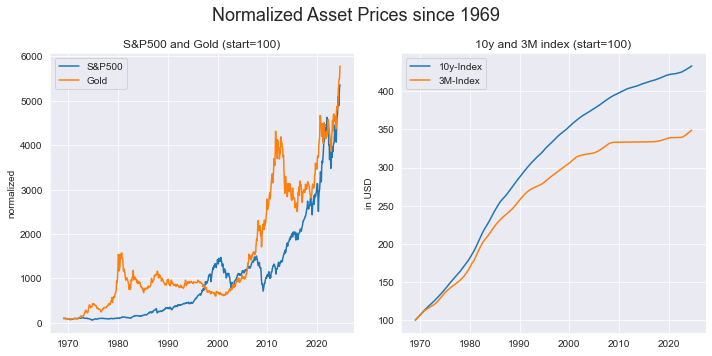

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df['SP500_adjs'] = df['SP500']/df['SP500'][0] * 100
df['Gold_adjs'] = df['Gold']/df['Gold'][0] *100

axes[0].plot(df[['SP500_adjs','Gold_adjs']], label=['S&P500','Gold'])
axes[0].set_title('S&P500 and Gold (start=100)')
#axes[0].set_yscale('log')
axes[0].set_ylabel('normalized')
axes[0].legend()

axes[1].plot(df[['10y treasury Index','3M-Index']], label=['10y-Index','3M-Index'])
axes[1].set_title('10y and 3M index (start=100)')
axes[1].set_ylabel('in USD')
axes[1].legend()

plt.suptitle('Normalized Asset Prices since 1969', fontsize = 18)
plt.tight_layout()
plt.show()

# Augmented Dickey–Fuller Stationarity Test

In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

### Test for stationarity

In [10]:
# Test if time series are stationary
# ADF Test on each column
for name, column in df.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SP500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 3.6935
 No. Lags Chosen       = 18
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 1.0. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.104
 No. Lags Chosen       = 12
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.9953. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "3M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

In [11]:
# take difference of time series to avoid stationarity
df_test_stationary = df[['SP500', 'Gold', '3M-Index', '10y treasury Index']].diff().dropna()

In [12]:
# ADF Test on each column
for name, column in df_test_stationary.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "SP500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2824
 No. Lags Chosen       = 20
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Gold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1863
 No. Lags Chosen       = 11
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "3M-Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

# Estimate vector autoregressive (VAR) model

In [13]:
model = VAR(df_test_stationary)

/Users/johanneswinkler/miniforge3/envs/thesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)


In [14]:
# find the best lag
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,8.895,8.923,7296.,8.906
1,2.473,2.610,11.86,2.526
2,2.239,2.486*,9.379,2.335*
3,2.229,2.587,9.293,2.368
4,2.238,2.705,9.371,2.419
5,2.264,2.842,9.622,2.488
6,2.293,2.981,9.905,2.560
7,2.222,3.020,9.229,2.532
8,2.225,3.133,9.259,2.577
9,2.203,3.221,9.058,2.598


In [15]:
# fit the model and determine lag order
model_fitted = model.fit()
lag_order = model_fitted.k_ar
print("lag order: ", lag_order)

lag order:  1


In [16]:
# summary of model
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Dec, 2024
Time:                     08:12:39
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    2.56300
Nobs:                     665.000    HQIC:                   2.48011
Log likelihood:          -4561.58    FPE:                    11.3325
AIC:                      2.42767    Det(Omega_mle):         10.9980
--------------------------------------------------------------------
Results for equation SP500
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        31.349246         6.889582            4.550           0.000
L1.SP500                     -0.099898         0.038997           -2.562           0.010
L1.Gold                     

## Durbin-Watson for autocorrelation

In [17]:
# test if residuals are serialy correlated
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_test_stationary.columns, out):
    print(col, ':', round(val, 2))

SP500 : 2.02
Gold : 2.0
3M-Index : 1.3
10y treasury Index : 2.06


#### for the 3M-index can null hypthesis cannot clearly be rejected but it is close enough

## Visual inspection of fit of VAR model

In [18]:
# data only for assets
df_assets = df[['SP500', 'Gold', '3M-Index', '10y treasury Index']]

# divide dataset in train and test data
n = len(df_test_stationary)
ratio = 0.8

train_df_stationary = df_test_stationary[0:int(n*ratio)]
test_df_stationary = df_test_stationary[int(n*ratio):]

train_df = df_assets[0:int(n*ratio)]
test_df = df_assets[int(n*ratio):]

In [19]:
# train modell on trainings data
model_train = VAR(train_df_stationary)
model_train_fitted = model_train.fit()
lag_order = model_train_fitted.k_ar

/Users/johanneswinkler/miniforge3/envs/thesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)


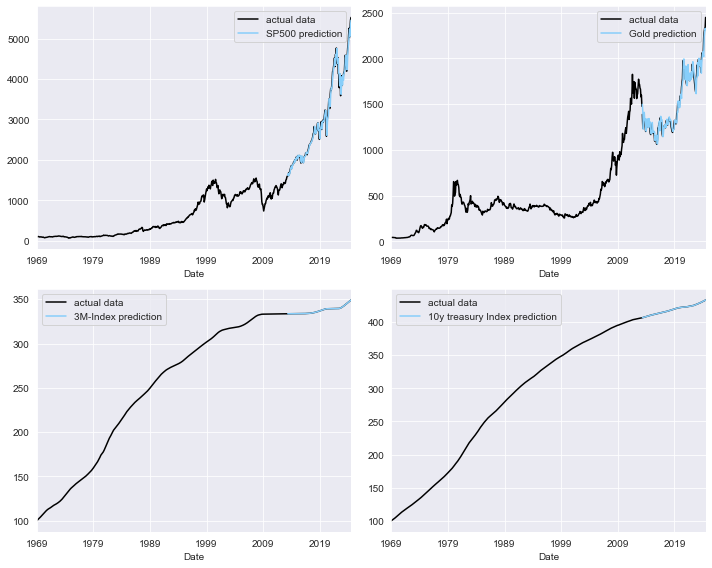

In [20]:
sns.set_style('darkgrid')
forecast_window = 1

# create dataframes to store the results
df_results = pd.DataFrame(columns=train_df.columns, index=test_df.index)
df_forecast = pd.DataFrame(columns=train_df.columns, index=test_df.index)

# initial value
forecast_input = train_df_stationary.values[-lag_order:]
fc = model_train_fitted.forecast(y=forecast_input, steps=forecast_window)
df_forecast.iloc[0,:] = fc
df_results.iloc[0,:] = train_df.iloc[-1,:].values + fc[0]

# all subsequent values
for i in range(1,len(test_df)):
    forecast_input = test_df_stationary.values[i-lag_order:i]
    fc = model_train_fitted.forecast(y=forecast_input, steps=forecast_window)
    df_forecast.iloc[i,:] = fc
    df_results.iloc[i,:] = test_df.iloc[i-1,:] + fc[0]

# plot the results
#fig, axes = plt.subplots(nrows=len(df_test.columns),figsize=(10,20))
fig, axes = plt.subplots(2,2, figsize=(10,8))
for i, (col,ax) in enumerate(zip(train_df.columns, axes.flatten())):
    train_df[col].plot(legend=True, ax=ax, color='black', label='actual data')
    test_df[col].plot(legend=False, ax=ax, color='black', label='test data')
    df_results[col].plot(legend=True, ax=ax, color='lightskyblue', label=col+ ' prediction').autoscale(axis='x',tight=True)

plt.tight_layout()